In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [2]:
image_dir = Path('/content/diabetic-retinopathy-dataset/')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [3]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Label
0,../input/diabetic-retinopathy-224x224-gaussian...,Mild
1,../input/diabetic-retinopathy-224x224-gaussian...,Moderate
2,../input/diabetic-retinopathy-224x224-gaussian...,Moderate


# Visualization

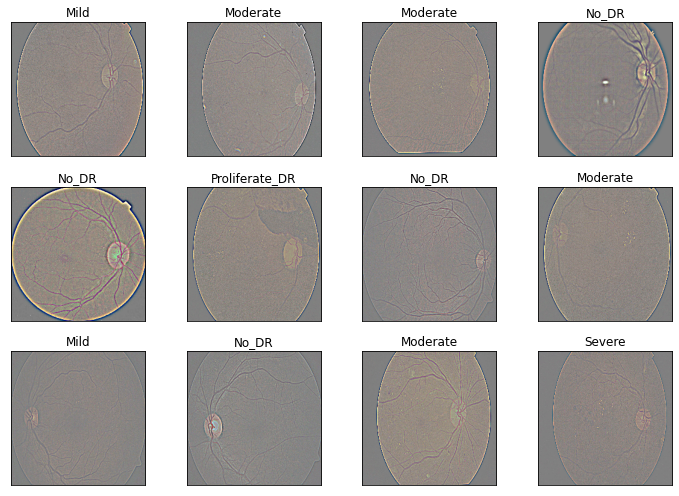

In [4]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

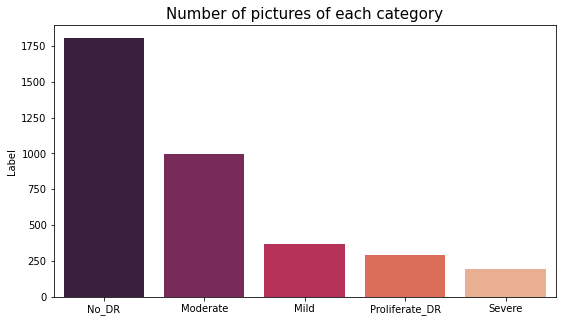

In [5]:
# Display the number of pictures of each category
vc = image_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

# Load the Images with a generator<a class="anchor" id="2"></a>

In [6]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [7]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [8]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [9]:
# Dictionary with the models
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0}
}

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Fit the models
for name, model in models.items():
    
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=1)
    
    # Sav the duration, the train_accuracy and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]
    
    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v,4) for v in train_acc]

Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.


93/93 [==============================] - 41s 352ms/step - loss: 0.9320 - accuracy: 0.6635 - val_loss: 0.6554 - val_accuracy: 0.7751
DenseNet121          trained in 41.58 sec
93/93 [==============================] - 25s 185ms/step - loss: 0.9310 - accuracy: 0.6486 - val_loss: 0.6093 - val_accuracy: 0.7720
DenseNet169          trained in 24.73 sec
93/93 [==============================] - 27s 193ms/step - loss: 0.9767 - accuracy: 0.6405 - val_loss: 0.7081 - val_accuracy: 0.7568
InceptionResNetV2    trained in 27.54 sec
93/93 [==============================] - 18s 153ms/step - loss: 1.0458 - accuracy: 0.5938 - val_loss: 0.6999 - val_accuracy: 0.7720
InceptionV3          trained in 18.06 sec
93/93 [==============================] - 15s 139ms/step - loss: 0.9253 - accuracy: 0.6776 - val_loss: 0.6005 - val_accura

In [10]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, 
                          models[name]['train_accuracy'][-1],
                          models[name]['val_acc'][-1], 
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','train_accuracy','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,train_accuracy,val_accuracy,Training time (sec)
0,MobileNet,0.7320,0.7781,14.93
1,MobileNetV2,0.7144,0.7781,15.86
2,DenseNet121,0.6922,0.7751,41.58
3,DenseNet169,0.7124,0.7720,24.73
4,InceptionV3,0.6797,0.7720,18.06
5,InceptionResNetV2,0.6888,0.7568,27.54
6,VGG19,0.6527,0.7264,14.11
7,ResNet101,0.6416,0.7143,20.86
8,VGG16,0.6396,0.7143,15.27
9,ResNet50,0.6470,0.6930,17.46


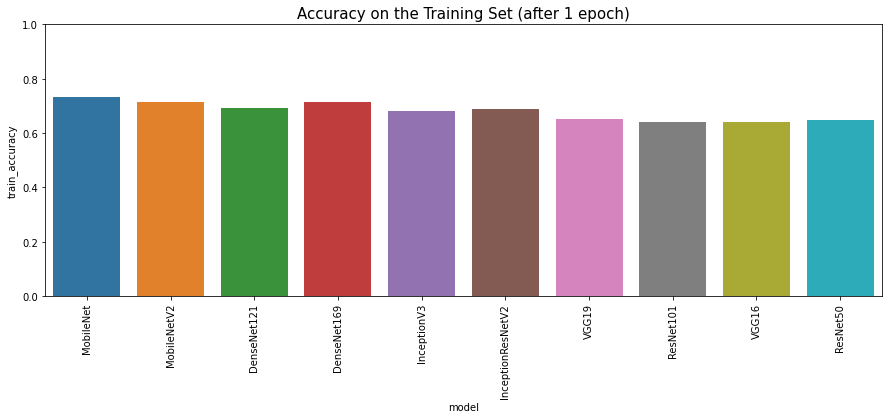

In [11]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'train_accuracy', data = df_results)
plt.title('Accuracy on the Training Set (after 1 epoch)', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

# ResNet101<a class="anchor" id="4"></a>

In [12]:
# Load the pretained model
pretrained_model = tf.keras.applications.ResNet101(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [16]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy','AUC']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
93/93 [==============================] - 22s 176ms/step - loss: 1.0791 - accuracy: 0.5900 - auc: 0.8410 - val_loss: 0.8804 - val_accuracy: 0.6839 - val_auc: 0.8976
Epoch 2/10
93/93 [==============================] - 14s 154ms/step - loss: 0.9292 - accuracy: 0.6597 - auc: 0.8843 - val_loss: 0.8475 - val_accuracy: 0.6839 - val_auc: 0.9103
Epoch 3/10
93/93 [==============================] - 14s 148ms/step - loss: 0.9027 - accuracy: 0.6599 - auc: 0.8925 - val_loss: 0.8145 - val_accuracy: 0.7264 - val_auc: 0.9165
Epoch 4/10
93/93 [==============================] - 14s 149ms/step - loss: 0.8566 - accuracy: 0.6817 - auc: 0.9050 - val_loss: 0.7998 - val_accuracy: 0.7234 - val_auc: 0.9171
Epoch 5/10
93/93 [==============================] - 14s 152ms/step - loss: 0.8734 - accuracy: 0.6763 - auc: 0.8988 - val_loss: 0.7958 - val_accuracy: 0.7234 - val_auc: 0.9189
Epoch 6/10
93/93 [==============================] - 14s 149ms/step - loss: 0.8029 - accuracy: 0.7075 - auc: 0.9160 - val_loss

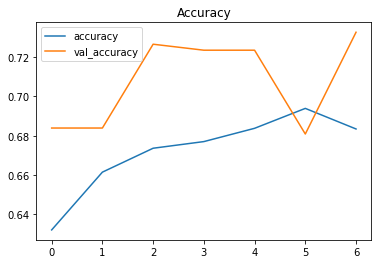

In [17]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

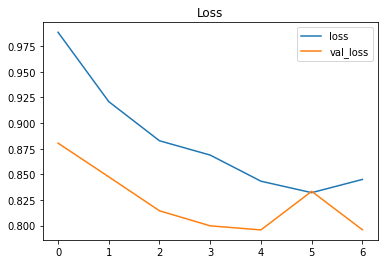

In [18]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [19]:
results = model.evaluate(test_images, verbose=0)

In [20]:
printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))

 ## Test Loss: 0.84818

## Accuracy on the test set: 70.30%

In [21]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Moderate', 'Moderate', 'Moderate', 'No_DR', 'Moderate']


In [22]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(y_test, pred),5))
print('Precision:', np.round(metrics.precision_score(y_test, pred, average='weighted'),5))
print('Recall:', np.round(metrics.recall_score(y_test,pred, average='weighted'),5))
print('F1 Score:', np.round(metrics.f1_score(y_test, pred, average='weighted'),5))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, pred),5))
print(classification_report(y_test, pred))

Accuracy: 0.703
Precision: 0.59958
Recall: 0.703
F1 Score: 0.6416
Cohen Kappa Score: 0.52684
                precision    recall  f1-score   support

          Mild       0.37      0.21      0.27        33
      Moderate       0.59      0.84      0.69       116
         No_DR       0.84      0.93      0.88       166
Proliferate_DR       0.00      0.00      0.00        38
        Severe       0.00      0.00      0.00        14

      accuracy                           0.70       367
     macro avg       0.36      0.40      0.37       367
  weighted avg       0.60      0.70      0.64       367



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: 

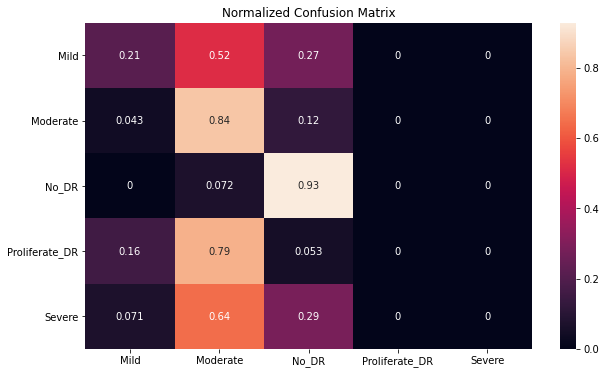

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

# Using a two-class model (DR and No_DR)<a class="anchor" id="7"></a>

As we have seen before, the prediction are very accurate to predict if someone has Diabetic Retinopathy or not. Nevertheless, it is not good at predicting the intensity of Diabetic Retinopathy when it is present. Maybe because it is subjective to the doctor to rate the intensity degree and different doctors don't have the same way to evaluate them. Maybe there are other factors taken in consideration to evaluate the intensity, which are independent from the pictures. As this point, without knowing more about the data, we can only speculate.

In this chapter, we'll reduce the label to a two-class model, because we can imagine that the most important part of this analysis is to find out if someone has Diabetic Retinopathy or not.

In [24]:
# Map the labels to have only "No_DR" and "DR"
image_df_red = image_df.copy()
image_df_red['Label'] = image_df_red['Label'].apply(lambda x: x if x == 'No_DR' else 'DR')
image_df_red.head(5)

,Filepath,Label
0,../input/diabetic-retinopathy-224x224-gaussian...,DR
1,../input/diabetic-retinopathy-224x224-gaussian...,DR
2,../input/diabetic-retinopathy-224x224-gaussian...,DR
3,../input/diabetic-retinopathy-224x224-gaussian...,No_DR
4,../input/diabetic-retinopathy-224x224-gaussian...,No_DR


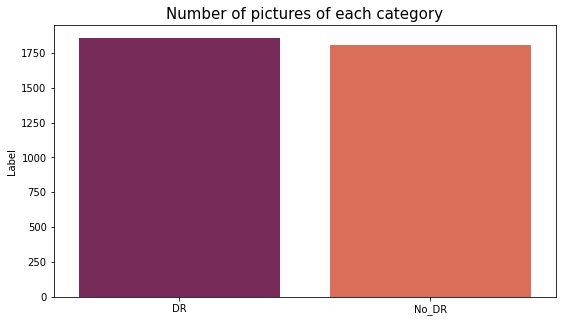

In [25]:
# Display the number of pictures of each category
vc = image_df_red['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [26]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df_red, train_size=0.9, shuffle=True, random_state=1)

In [27]:
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()

# Load the pretained model
pretrained_model = tf.keras.applications.ResNet101(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False


inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy','AUC']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Found 2966 validated image filenames belonging to 2 classes.
Found 329 validated image filenames belonging to 2 classes.
Found 367 validated image filenames belonging to 2 classes.
Epoch 1/10
93/93 [==============================] - 21s 169ms/step - loss: 0.4215 - accuracy: 0.8183 - auc: 0.8753 - val_loss: 0.3116 - val_accuracy: 0.8602 - val_auc: 0.9428
Epoch 2/10
93/93 [==============================] - 15s 156ms/step - loss: 0.2826 - accuracy: 0.8872 - auc: 0.9511 - val_loss: 0.3049 - val_accuracy: 0.8632 - val_auc: 0.9453
Epoch 3/10
93/93 [==============================] - 14s 150ms/step - loss: 0.2847 - accuracy: 0.8808 - auc: 0.9509 - val_loss: 0.3143 - val_accuracy: 0.8632 - val_auc: 0.9432
Epoch 4/10
93/93 [==============================] - 14s 148ms/step - loss: 0.2844 - accuracy: 0.8795 - auc: 0.9501 - val_loss: 0.2834 - val_accuracy: 0.8906 - val_auc: 0.9514
Epoch 5/10
93/93 [==============================] - 14s 150ms/step - loss: 0.2560 - accuracy: 0.8906 - auc: 0.9598 - va

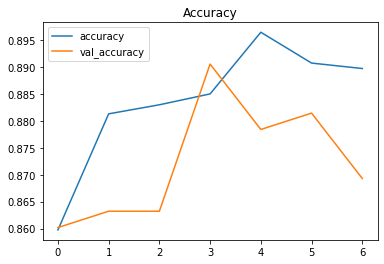

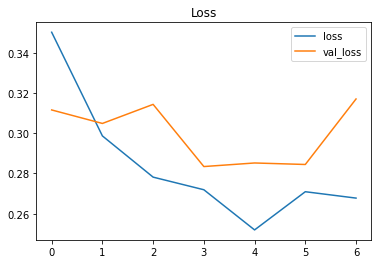

 ## Test Loss: 0.26515

## Accuracy on the test set: 88.56%



Accuracy: 0.88556
Precision: 0.88633
Recall: 0.88556
F1 Score: 0.88571
Cohen Kappa Score: 0.76974
              precision    recall  f1-score   support

          DR       0.91      0.88      0.89       201
       No_DR       0.86      0.89      0.88       166

    accuracy                           0.89       367
   macro avg       0.88      0.89      0.88       367
weighted avg       0.89      0.89      0.89       367



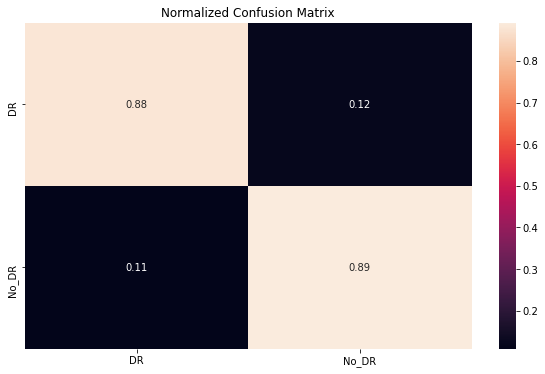

In [28]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

results = model.evaluate(test_images, verbose=0)

printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))
print('\n')

# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

from sklearn.metrics import classification_report
y_test = list(test_df.Label)
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(y_test,pred),5))
print('Precision:', np.round(metrics.precision_score(y_test,pred, average='weighted'),5))
print('Recall:', np.round(metrics.recall_score(y_test,pred, average='weighted'),5))
print('F1 Score:', np.round(metrics.f1_score(y_test,pred, average='weighted'),5))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test,pred),5))
print(classification_report(y_test, pred))

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()